In [50]:
import pandas as pd
import numpy as np
import mysql.connector
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

In [51]:
# order of ops
# model architecture and advanced layers
# hyperparameter tuning (optuna)
# loss function
# learning rate scheduling

Database Interaction

In [52]:
db_config = {
    "host": "10.200.200.107",
    "user": "scriptuser1",
    "password": "YabinMarshed2023@#$",
    "database": "biomech_pitching_db"
}

connection = mysql.connector.connect(**db_config)
query = 'SELECT * FROM bp_poi_metrics INNER JOIN bp_sessions ON bp_poi_metrics.session = bp_sessions.session;'
df = pd.read_sql(query, connection)
connection.close()

C:\Users\adam.bloebaum\AppData\Local\Temp\ipykernel_12440\1654787200.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Preprocessing

In [53]:
# Drop columns with nan values
columns_with_nan = df.columns[df.isna().any()].tolist()
cleaned_df = df.drop(columns=columns_with_nan)

# Drop unneeded columns
columns_to_exclude = ['session_pitch', 'session', 'p_throws', 'pitch_type', 'session', 'session_date', 'user', 'session_tag', 'session_location', 'playing_level', 'irb']
cleaned_df = cleaned_df.drop(columns=columns_to_exclude)

Feature Engineering

In [54]:
# Engineer features relative to body weight
bw = 'session_mass_kg'
exclude = (bw, 'pitch_speed_mph')
for col in cleaned_df.columns:
    if col not in exclude:
        cleaned_df[f'{col}_rel_{bw}'] = cleaned_df[col] / cleaned_df[bw]

Feature Importance

In [55]:
# Split features and Labels
X = cleaned_df.drop('pitch_speed_mph', axis=1)
y = cleaned_df['pitch_speed_mph']

# Create the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X, y)

# Get feature importances
feature_importances = xgb_model.feature_importances_

importance_threshold = 0.0025  # Define a threshold for feature importance
important_features_indices = [i for i, imp in enumerate(feature_importances) if imp > importance_threshold]
important_features = [X.columns[i] for i in important_features_indices]
important_feature_importances = feature_importances[important_features_indices]
X_important = cleaned_df[important_features]

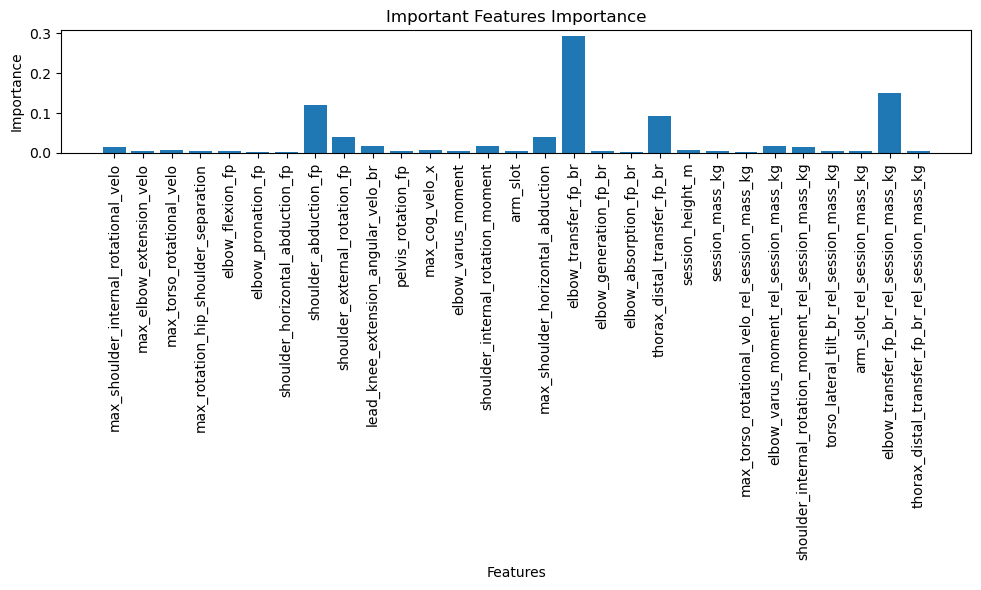

In [56]:
plt.figure(figsize=(10, 6))
plt.bar(important_features, important_feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.title('Important Features Importance')
plt.tight_layout()
plt.show()

Preprocessing

In [57]:
# Split features and labels
X = X_important
y = cleaned_df['pitch_speed_mph']
X.to_csv('nn_features.csv')
y.to_csv('nn_labels.csv')

# Split the data into 80% train and 20% combined validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into 50% validation and 50% test (10% of total each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training, validation, and test data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Define Model

In [32]:
# 10 mse, 35 training loss
class PitchVelocityModel(nn.Module):
    def __init__(self, num_features):
        super(PitchVelocityModel, self).__init__()
        # Fully connected layers
        self.fc1 = torch.nn.Linear(num_features, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 64)
        self.fc6 = torch.nn.Linear(64, 32)
        self.fc7 = torch.nn.Linear(32, 1)
        
        # Relu activation function
        self.relu = torch.nn.ReLU()  
                
    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

Initialize Hyperparameters

In [33]:
model = PitchVelocityModel(X_train.shape[1])

# Check for GPU availability and enable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Mean Squared Error Loss for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


Train Model

Epoch 0, Loss: 1084.492385680859
Epoch 10, Loss: 95.40214584653194
Epoch 20, Loss: 83.52995356458884
Epoch 30, Loss: 88.69501059330426
Epoch 40, Loss: 66.1517103772897
Epoch 50, Loss: 44.41486630072961
Epoch 60, Loss: 72.63248893962457
Epoch 70, Loss: 47.80693075863215
Epoch 80, Loss: 39.49329224228859
Epoch 90, Loss: 45.270868079020424


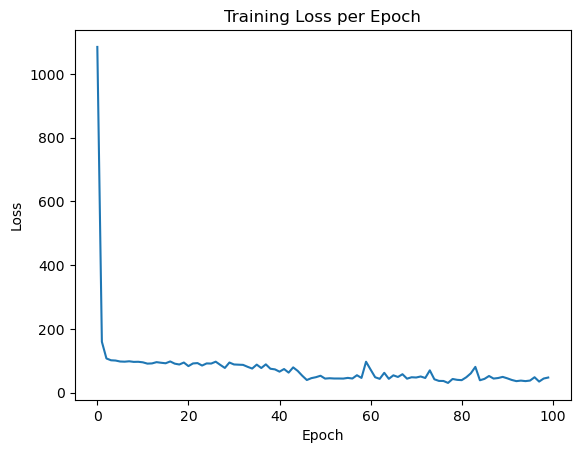

In [34]:
# List to store losses
losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        # Move the data to the device
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss}')

# Plotting the training loss
plt.plot(losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Evaluate Model

In [35]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
y_pred_list = []

# No gradients need to be calculated during evaluation
with torch.no_grad():
    for X_batch, _ in test_loader:
        # Move the batch to the device the model is on (GPU if available)
        X_batch = X_batch.to(device)

        # Perform the forward pass and get the predictions
        y_val_pred = model(X_batch)

        # Move the predictions back to CPU and convert them to numpy for further processing
        y_pred_list.append(y_val_pred.cpu().numpy())

# Flatten the list of arrays and convert it to a single numpy array
y_pred_flat = np.concatenate(y_pred_list).ravel()

# Ensure y_test_tensor is also a numpy array and has the same shape
# Also, ensure that y_test_tensor is on the CPU before converting to numpy
y_test_numpy = y_test_tensor.cpu().numpy().ravel()

# Now compute MSE
mse = mean_squared_error(y_test_numpy, y_pred_flat)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 10.971242904663086


Save/Load Model

In [36]:
# Save
joblib.dump(scaler, 'scaler.pk1')
torch.save(model.state_dict(), 'pitch_velocity_model.pth')

In [ ]:
# Load
model = PitchVelocityModel(X_train.shape[1])
model.load_state_dict(torch.load('pitch_speed_predictor_model.pth'))
model.eval()